In [1]:
%matplotlib inline

import os 
import glob 
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import time
import datetime
import matplotlib.pyplot as plt
from scipy.stats import zscore

plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
sns.set_style("ticks")

In [2]:
# aesthetics
# aesthetics

cmap_timepoint = {v:sns.color_palette('BuGn')[1:][i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_genotime = {}
for g in ['WT', 'SCA1']:
    if g=='WT':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5, start=.5, rot=-.75)[i]
    if g=='SCA1':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5)[i]
            
cmap_ctype={'Granule cell': '#FAC18A',
            'Unipolar brush cell': '#BA61BA',
            'Purkinje cell': '#EE5264',
            'GABAergic interneuron 1': '#F9EBAE',
            'GABAergic interneuron 2': '#88BB92',
            'GABAergic interneuron 3': '#46A928',
            'Astrocyte': '#F9AEAE',
            'Bergmann glia': '#AEB7F9',
            'Oligodendrocyte progenitor cell': '#F1815F',
            'Oligodendrocyte': '#75A3B7',
            'Microglia': '#AC5861',
            'Pericyte': '#2D284B',
            'Endothelial cell': '#1C67EE',
            'Deep cerebellar nuclei': '#aaaaaa'}

cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}



In [3]:
def load_mouse(file='/home/ngr4/project/scnd/data/processed/mouse_210726.h5ad'):
    return sc.read(file)

adata = load_mouse()

In [4]:
pfp = '/home/ngr4/project/scnd/results/'

In [5]:
w_top_scaled_combined = pd.read_csv(os.path.join(pfp, 'model_saliency_range_scaled.csv'), index_col=0)

In [6]:
for i in adata.obs.ctype_ubcupdate.unique():
    print(i)

Bergmann glia
Granule cell
Astrocyte
Oligodendrocyte
Deep cerebellar nuclei
GABAergic interneuron 1
Microglia
GABAergic interneuron 2
Unipolar brush cell
Endothelial cell
Pericyte
Purkinje cell
GABAergic interneuron 3
Oligodendrocyte progenitor cell


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


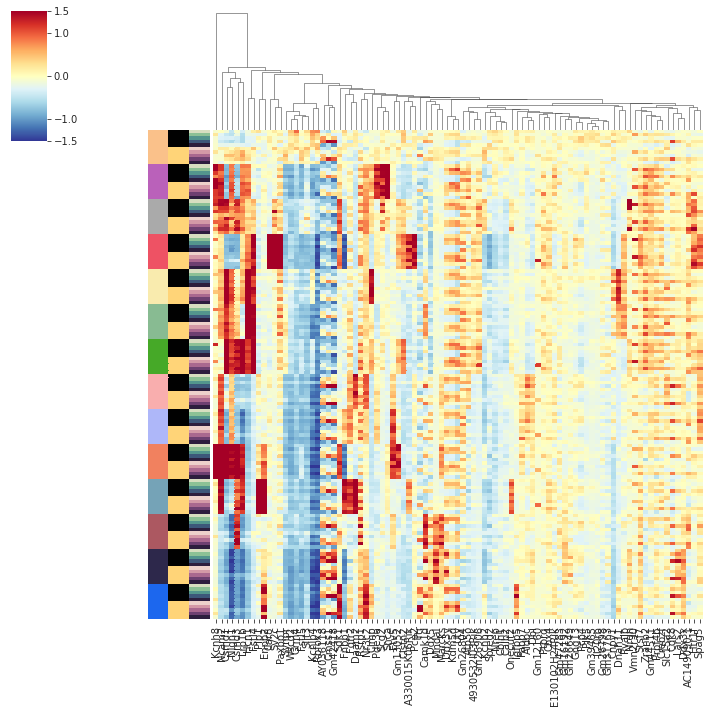

In [7]:
gene_list = list(set(w_top_scaled_combined['index']))

X = pd.DataFrame(adata[:, gene_list].X.todense(), index=adata.obs.index.to_list(), columns=gene_list)
X['ctype'] = adata.obs['ctype_ubcupdate'].to_list()
X['genotype'] = adata.obs['genotype'].to_list()
X['timepoint'] = adata.obs['timepoint'].to_list()
X['genotime'] = (adata.obs['genotype'].astype(str) + '_' + adata.obs['timepoint'].astype(str)).to_list()
X.loc[:, gene_list] = zscore(X.loc[:, gene_list])

genotime = True

 # set order manually
if not genotime:
    x = X.groupby(['ctype', 'genotype', 'timepoint']).mean().reset_index() 
    dt = pd.DataFrame()
    for ctype in [
        'Granule cell', 
        'Unipolar brush cell', 
        'Deep cerebellar nuclei',
        'Purkinje cell', 
        'GABAergic interneuron 1',
        'GABAergic interneuron 2',
        'GABAergic interneuron 3',
        'Astrocyte',
        'Bergmann glia', 
        'Oligodendrocyte progenitor cell',
        'Oligodendrocyte',
        'Microglia',
        'Pericyte',
        'Endothelial cell']:
        for genotype in ['WT','SCA1']:
            for timepoint in ['5wk','12wk','18wk','24wk','30wk']:
                dt = dt.append(x.loc[((x['ctype']==ctype) & (x['genotype']==genotype) & (x['timepoint']==timepoint)), :])
    x = dt
    del dt, X

    row_colors = [
        x['ctype'].astype(str).map(cmap_ctype).to_list(),
        x['genotype'].astype(str).map(cmap_genotype).to_list(),
        x['timepoint'].astype(str).map(cmap_timepoint).to_list()
    ]



else:
    x = X.groupby(['ctype', 'genotime']).mean().reset_index()
    dt = pd.DataFrame()
    for ctype in [
        'Granule cell', 
        'Unipolar brush cell', 
        'Deep cerebellar nuclei',
        'Purkinje cell', 
        'GABAergic interneuron 1',
        'GABAergic interneuron 2',
        'GABAergic interneuron 3',
        'Astrocyte',
        'Bergmann glia', 
        'Oligodendrocyte progenitor cell',
        'Oligodendrocyte',
        'Microglia',
        'Pericyte',
        'Endothelial cell']:
        for genotime in [
            'WT_5wk',
            'WT_12wk',
            'WT_18wk',
            'WT_24wk',
            'WT_30wk',
            'SCA1_5wk',
            'SCA1_12wk',
            'SCA1_18wk',
            'SCA1_24wk',
            'SCA1_30wk',]:
            dt = dt.append(x.loc[((x['ctype']==ctype) & (x['genotime']==genotime)), :])
    x = dt
    del dt, X

    # add genotype
    x['genotype'] = ['WT' if 'WT' in i else 'SCA1' for i in x['genotime']]
    row_colors = [
        x['ctype'].astype(str).map(cmap_ctype).to_list(),
        x['genotype'].astype(str).map(cmap_genotype).to_list(),
        x['genotime'].astype(str).map(cmap_genotime).to_list(),
    ]



p0 = sns.clustermap(x.loc[:, gene_list], 
   row_cluster=False,
   row_colors=row_colors, 
   vmin=-1.5, vmax=1.5, 
   cbar_kws={'ticks':[-1.5,-1,0,1,1.5]}, 
   cmap='RdYlBu_r', 
   yticklabels=False, xticklabels=True)

p0.savefig(os.path.join(pfp, 'ave_zscore_GATtop_combinedTimepointModels_revision.pdf'), bbox_inches='tight')
